In [1]:
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import jgraph as ig
from py2neo import Graph, authenticate, Relationship
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
init_notebook_mode(connected=True)

In [2]:
authenticate("localhost:7474", "neo4j", "password")
graph = Graph()


In [3]:
query="""
MATCH (u:User)-[:Watched]->(m:Movie)<-[:Watched]-(u2:User)-[r:Watched]->(m2:Movie)
where u.Userid = '822109' and m.Movieid='1' and not (u)-[:Watched]->(m2)
return u2.Userid as Userid,m2.Movieid as Movieid,r.Rating as Rating,m2.Title as Title;
"""
result=graph.cypher.execute(query)




In [4]:

edgelist = pd.DataFrame.from_records(result.records, columns=result.columns)

In [5]:
# Create empty graph
g = nx.Graph()

In [6]:
# Add edges and edge attributes
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [7]:
# Edge list example
print(elrow[0]) # node1
print(elrow[1]) # node2
print(elrow[2:].to_dict()) # edge attribute dict

1578279
8
{'Rating': '1', 'Title': 'What the #$*! Do We Know!?'}


In [8]:
# Preview first 5 edges
g.edges(data=True)[0:5]

[('2374451', '253', {'Rating': '5', 'Title': 'A Night at the Opera'}),
 ('2374451', '252', {'Rating': '4', 'Title': 'Stuart Little 2'}),
 ('2374451', '241', {'Rating': '4', 'Title': 'North by Northwest'}),
 ('2374451', '216', {'Rating': '3', 'Title': 'Impostor'}),
 ('2374451', '199', {'Rating': '4', 'Title': 'The Deer Hunter'})]

In [9]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))
numNodes = g.number_of_nodes()



# of edges: 7637
# of nodes: 738


In [10]:
#trying yet another method
G = nx.Graph()


In [11]:
for (idx, row) in edgelist.iterrows():
    nodeId = row.loc['Userid']
    G.add_node(nodeId,{'color':1})
    nodeId = row.loc['Movieid']
    G.add_node(nodeId,{'color':2,'Title':row.loc['Title']})
    

for (idx, row) in edgelist.iterrows():
    G.add_edge(row.loc['Userid'],row.loc['Movieid'],weight=row.loc['Rating'])


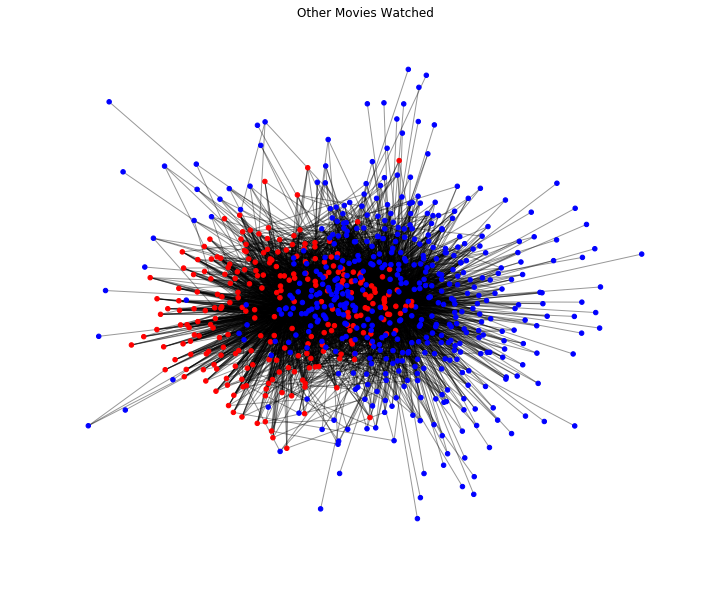

In [12]:
plt.figure(figsize=(12, 10))
#pos = nx.random_layout(g)
pos = nx.spring_layout(G)
#nx.draw(g,pos)

node_color = []
for node in G.nodes(data=True):
    # if the node has the attribute group1
    if (node[1]['color'] == 1):
        node_color.append('blue')
    else:
         node_color.append('red')

nx.draw_networkx_nodes(G, pos,node_size=20, node_color=node_color)
nx.draw_networkx_edges(G,pos, alpha =0.4)

edge_labels = nx.get_edge_attributes(G,'Rating')
#nx.draw_networkx_edge_labels(g, pos, labels = edge_labels)
plt.axis('off')
plt.title('Other Movies Watched')
plt.show()

In [13]:
query="""
MATCH (u:User {Userid:"822109"})-[:Watched]->(m:Movie {Movieid:"1"})<-[:Watched]-(u2:User)-[r:Watched]->(m2:Movie)
where not (u)-[:Watched]->(m2)
return distinct m2.Movieid as Movieid, m2.Title as Title, count(m2.Movieid) as Count
order by Count DESC
Limit 10;
"""
result=graph.cypher.execute(query)
result

    | Movieid | Title                      | Count
----+---------+----------------------------+-------
  1 | 191     | X2: X-Men United           |   292
  2 | 30      | Something's Gotta Give     |   237
  3 | 175     | Reservoir Dogs             |   224
  4 | 28      | Lilo and Stitch            |   223
  5 | 197     | Taking Lives               |   201
  6 | 58      | Dragonheart                |   163
  7 | 252     | Stuart Little 2            |   162
  8 | 143     | The Game                   |   154
  9 | 199     | The Deer Hunter            |   149
 10 | 118     | Rambo: First Blood Part II |   137

In [14]:
nodeCount = pd.DataFrame.from_records(result.records, columns=result.columns)
print(nodeCount)

  Movieid                       Title  Count
0     191            X2: X-Men United    292
1      30      Something's Gotta Give    237
2     175              Reservoir Dogs    224
3      28             Lilo and Stitch    223
4     197                Taking Lives    201
5      58                 Dragonheart    163
6     252             Stuart Little 2    162
7     143                    The Game    154
8     199             The Deer Hunter    149
9     118  Rambo: First Blood Part II    137


In [15]:
node_sizes = []
nodeSet = set(nodeCount['Movieid'])

print(nodeSet)
for node in G.nodes(data=True):
    if (node[0] in nodeSet):
        node_sizes.append(100)
    else:
        node_sizes.append(20)
        

{'28', '30', '199', '175', '191', '143', '118', '252', '58', '197'}


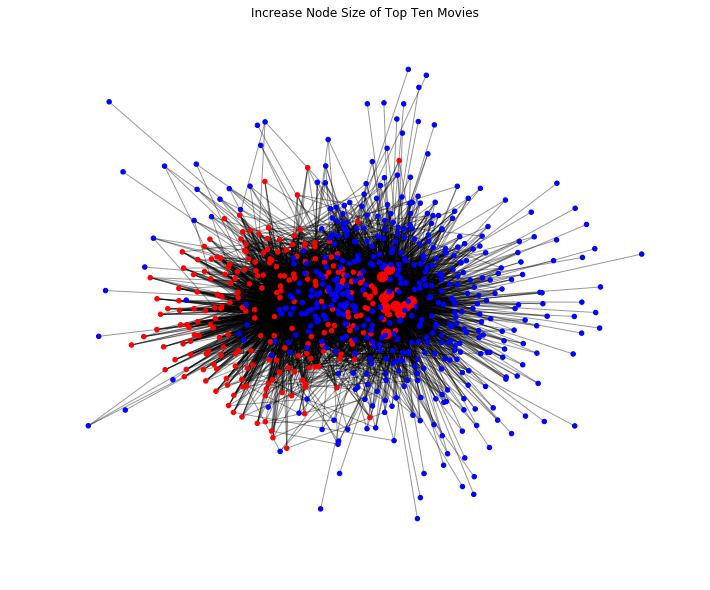

In [16]:
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos,node_size=node_sizes, node_color=node_color)
nx.draw_networkx_edges(G,pos, alpha =0.4)

#edge_labels = nx.get_edge_attributes(G,'Rating')
#nx.draw_networkx_edge_labels(g, pos, labels = edge_labels)
plt.axis('off')
plt.title('Increase Node Size of Top Ten Movies')
plt.show()

In [17]:
movieArray = np.array(nodeCount['Movieid'])
print(movieArray)

['191' '30' '175' '28' '197' '58' '252' '143' '199' '118']


In [18]:
query="""
MATCH (u:User {Userid:"822109"})-[:Watched]->(m:Movie {Movieid:"1"})<-[:Watched]-(u2:User)-[r:Watched]->(m2:Movie)
where m2.Movieid in ['191','30','175','28','197','58','252','143','199','118'] and not (u)-[:Watched]->(m2)
return u2.Userid as Userid,m2.Movieid as Movieid,r.Rating as Rating,m2.Title as Title;
"""
result=graph.cypher.execute(query)


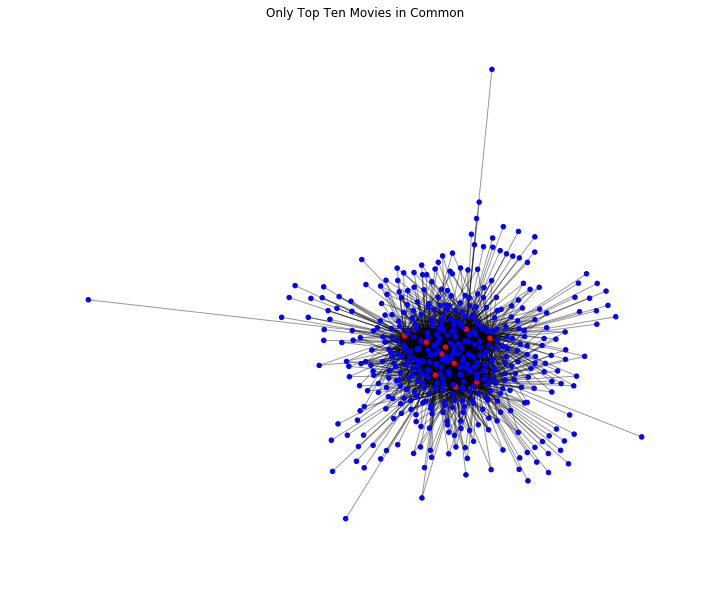

In [19]:
#trying yet another method
G = nx.Graph()
edgelist = pd.DataFrame.from_records(result.records, columns=result.columns)
# Add edges and edge attributes
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())
    
for (idx, row) in edgelist.iterrows():
    nodeId = row.loc['Userid']
    G.add_node(nodeId,{'color':1})
    nodeId = row.loc['Movieid']
    G.add_node(nodeId,{'color':2,'Title':row.loc['Title']})
    

for (idx, row) in edgelist.iterrows():
    G.add_edge(row.loc['Userid'],row.loc['Movieid'],weight=row.loc['Rating'])

plt.figure(figsize=(12, 10))
#pos = nx.random_layout(g)
pos = nx.spring_layout(G)
#nx.draw(g,pos)

node_color = []
for node in G.nodes(data=True):
    # if the node has the attribute group1
    if (node[1]['color'] == 1):
        node_color.append('blue')
    else:
         node_color.append('red')

nx.draw_networkx_nodes(G, pos,node_size=20, node_color=node_color)
nx.draw_networkx_edges(G,pos, alpha =0.4)

edge_labels = nx.get_edge_attributes(G,'Rating')
#nx.draw_networkx_edge_labels(g, pos, labels = edge_labels)
plt.axis('off')
plt.title('Only Top Ten Movies in Common')
plt.show()